In [1]:
import pandas as pd
from math import pi, sin, cos, exp, tan, acos, isclose

 
import numpy as np
import re
from itertools import groupby
from os import listdir, path
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import calendar
from prov.model import ProvDocument
import datetime
from prov.dot import prov_to_dot
from IPython.display import Image


In [2]:
pi = 3.1412

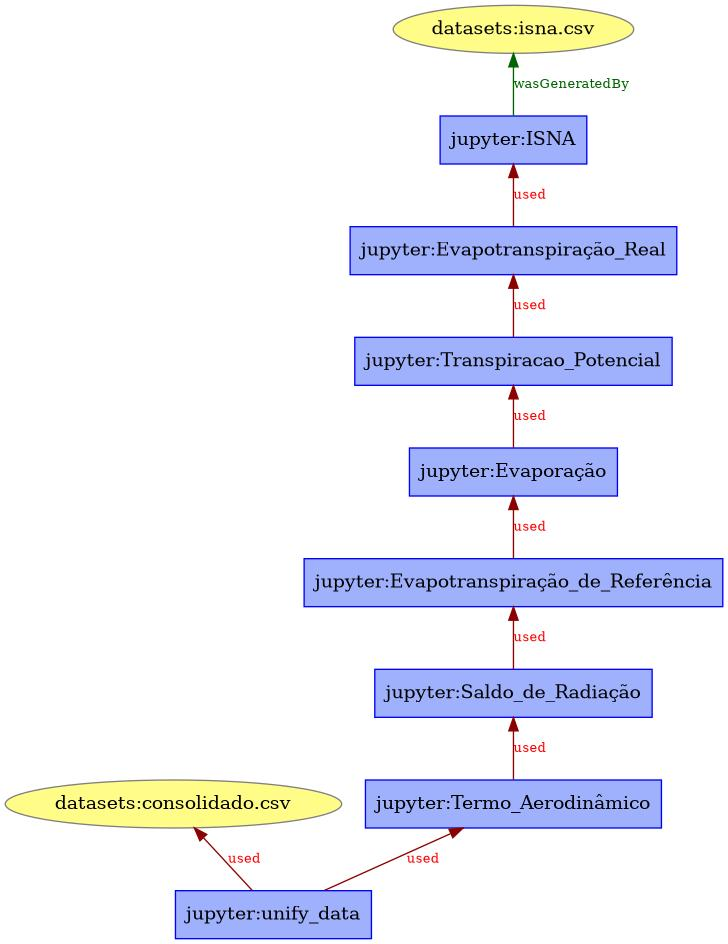

In [3]:
d1 = ProvDocument()

# Declaring namespaces for various prefixes used in the excution of Randon Walk Experiment
d1.add_namespace('inmet', 'datasets/consolidados.csv')
d1.add_namespace('foaf', 'http://xmlns.com/foaf/0.1/')
d1.add_namespace('datasets', 'datasets/')
d1.add_namespace('jupyter', 'KcDual-py.ipynb')
d1.add_namespace('local', 'zip')

# Adding an Agent 
#agent = 'foaf:AlexSantoss'
#d1.agent(agent)

# Adding an entity
entity = 'datasets:consolidado.csv'
e1 = d1.entity(entity)
 
entity = 'datasets:isna.csv'
e2 = d1.entity(entity)

#Generation
#a1 = 'local:conslidados'
#d1.activity(a1)

a2 = 'jupyter:unify_data'
d1.activity(a2)

a3 = 'jupyter:Termo_Aerodinâmico'
d1.activity(a3)

a4 = 'jupyter:Saldo_de_Radiação'
d1.activity(a4)

a5 = 'jupyter:Evapotranspiração_de_Referência'
d1.activity(a5)

a6 = 'jupyter:Transpiracao_Potencial'
d1.activity(a6)

a7 = 'jupyter:Evaporação'
d1.activity(a7)

a8 = 'jupyter:Transpiracao_Potencial'
d1.activity(a8)

a9 = 'jupyter:Evapotranspiração_Real'
d1.activity(a9)

a10 = 'jupyter:ISNA'
d1.activity(a10)


#Relations
#d1.used(a1, e1)
#d1.wasGeneratedBy(e1, a1)
d1.used(a2, e1)
d1.used(a2, a3) #Termo_Aerodinâmico
d1.used(a3, a4) #Saldo_de_Radiação
d1.used(a4, a5) #Evapotranspiração_de_referência
#d1.used(a5, a6) #Transpiracao_Potencial
d1.used(a5, a7) #Evaporação
d1.used(a7, a8) #Transpiracao_Potencial
d1.used(a8, a9) #Evapotranspiração_Real
d1.used(a9, a10) #ISNA

d1.wasGeneratedBy(a10, e2)

dot = prov_to_dot(d1)
graph = "dot.jpeg"
dot.write_jpeg(graph)
Image(graph)

# Dicinoário de Dados
COEFICIENTE_BASAL    => KCB\
COEFICIENTE_CULTURA  => KC\
COEFICIENTE_EVAPO    => KE\
EVAPO_CULTURA        => ETC\
TRANSP_POTENCIAL     => TRP\
EVAPO                => E\
ARMAZENAMENTO_AGUA   => ARM\
Capacidade de Campo  => TAR\
ARM2                 => ARM2\
EVAPO_REFERENCIA     => ET0\
EVAPO_REAL           => ETR\
TR                   => TR\
TA                   => TA\
DIAJULIANO           => DIAJULIANO\
TARMEDIO             => TAR/2 \
Indice de Satisfação => ISNA\
PLUVIOSIDADE         => P\


In [4]:
#Termo Aerodinâmico    
def termoAeroDinamico(params, urx, urn, tx, tn):
    tm   = (tx + tn)/2
    #Pressão de saturação do vapor d'água do ar - Equação de Tetens [kPa]
    es   = (0.6108* exp(17.27*tx/(237.3+tx))+ 0.6108* exp(17.27*tn/(237.3+tn)))/2
    #Pressão real do vapor d'água do ar [kPa]   
    ea   = (urn * 0.6108* exp(17.27*tx/(237.3+tx))+ urx * 0.6108* exp(17.27*tn/(237.3+tn)))/ 200
    #Declividade da curva de pressão de saturação [kPa/oC]
    S    = 4098 * 0.6108* exp(17.27*tm/(237.3+tm))/((237.3 + tm)**2)
    #Pressão atmosférica [kPa]
    Patm = 101.3*((293-0.0065*params.Z)/(293))**5.26
    #Calor latente de evaporação [MJ/kg]
    lamb = 0.665E-3*Patm
    
    return S, tm, es, ea, lamb

#Termo Radioativo
def saldoDeRadiacao(params, doy, qg, tx, tn, ea):
    #Radiação solar extraterrestre

    #Correção relativa Terra-Sol
    dr   = 1 + 0.033 * cos(2*pi/365*doy)
    #Declinação Solar 
    decl = 0.409 * sin((2*pi/365*doy)-1.39)
    #Angulo Horário
    ws   = acos(-tan(params.FI*pi/180)*tan(decl))
    #Radiação Solar Extraterrestre
    Qo   = 37.568*dr*((ws*sin(params.FI*pi/180)*sin(decl))+(cos(params.FI*pi/180)*cos(decl)*sin(ws)))

    #Balanço de radiação
    #Ondas curtas
    
    #Radiação solar para dia de céu sem nebulosidade
    Qso = (0.75 + 2E-5*params.Z)*Qo
    Qoc = 0.77 * qg
    
    #Ondas longas
    Qol    = 4.903E-9*((((tx + 273.16)**4)+ ((tn + 273.16)**4))/2)*(0.34-0.14*ea**0.5)*(1.35*(qg/Qso)-0.35)

    return Qoc - Qol

#Transpiração Potencial
def transpiracaoPotencial(params, u2, urn, aETo_PM, t):
    if t < params.L_INI:
        Kcb = params.KCB_INI
    elif t < params.L_INI + params.L_CRES:
        Kcb = params.KCB_INI+(t-params.L_INI)/params.L_CRES*(params.KCB_MID-params.KCB_INI)
    elif t < params.L_INI + params.L_CRES + params.L_MID:
        Kcb = params.KCB_MID
    else:
        Kcb = params.KCB_MID+(t-(params.L_INI+params.L_CRES+params.L_MID))/params.L_FIM*(params.KCB_FIM-params.KCB_MID)
    
    trp = Kcb * aETo_PM
    h = max((Kcb/params.KCB_MID)*params.HX,params.H)
    kcx = max(1.2+(0.04*(u2-2)-0.004*(urn-45))*(h/3)**0.3,Kcb+0.05)

    return Kcb, trp, h, kcx

#Balanço de água no solo
def evaporacao(params, p, Kcb, kcx, ETo_PM, De_f, h, t):
    #Camada subsuperfícial - Evaporação
    fc = max(abs(((Kcb-params.KCB_INI)/(kcx-params.KCB_INI)))**(1 + 0.5*params.H),0.01)
    
    if p > 0: fw = 1
    else: fw = params.FW_INI
    
    few = min(1-fc,fw)
    TAE = 1000*(params.CC-0.5*params.PM)*params.ZE
    
    if t == 1: De_i = TAE - params.AFE
    else: De_i = max(De_f-p, 0)
        
    if De_i < params.AFE: kr = 1
    else: kr = max((TAE - De_i)/(TAE - params.AFE), 0)
            
    ke = min(kr*(kcx-Kcb), few*kcx)
    E = ke * ETo_PM
    
    if t == 1:
        Dp = max(p, 0)
        De_f = min(De_i - p+(E/few) + Dp, TAE)
    else:
        Dp = max(p-De_f, 0)
        De_f = min(De_f - p+(E/few) + Dp, TAE)
        
    Kc = Kcb + ke
    ETc = Kc * ETo_PM

    return ETc, ke, De_f, De_i


def evapotranspiracaoReal(params, ap, aKcb, aETc, aKe, aETo_PM, De_i, Dr_f, t):
    if t <= (params.L_INI + params.L_CRES + params.L_MID):
        Zr = ((aKcb - params.KCB_INI)/(params.KCB_MID - params.KCB_INI))*(params.ZRX - params.ZRN) + params.ZRN
    else:
        Zr = params.ZRN
    
    TAR = 1000.*(params.CC - params.PM)*Zr
    AFR = params.F*TAR
    
    if t == 1:
        Dr_i = min( max((TAR-AFR)-ap+aETc, 0), TAR)
        if Dr_i < AFR:
            ks = 1
        else:
            ks = max( (TAR-Dr_i)/(TAR-AFR), 0)

        Dp = max( ap-aETc-Dr_i, 0 )
        kcr = aKe + ks * aKcb
        ETR = kcr * aETo_PM
        Tr = ks * aKcb *aETo_PM
        Dr_f = max( min((TAR-AFR)-ap+ETR+Dp, TAR), 0 )
    else:
        Dr_i = min( max(Dr_f-ap+aETc, 0), TAR)
        if Dr_i < AFR:
            ks = 1
        else:
            ks = max( (TAR-Dr_i)/(TAR-AFR), 0)
        
        Dp = max( ap-aETc-Dr_f, 0)
        kcr = aKe + ks*aKcb
        ETR = kcr * aETo_PM
        Tr = ks*aKcb*aETo_PM
        Dr_f = min(Dr_f-ap+ETR+Dp, TAR)

    return  TAR, Dr_f, ETR

In [36]:
def main():
    todos = []
    for k, v in dados.groupby(level=[0, 1, 2, 3]):
        isnas = []
        for i in range(10):
            De_f = De_i = Dr_f = 0
            isna_array = [0, 0, 0, 0, 0, 0]
            for idx, (_, (dia, _, _, _, ap, qg, tx, tn, urx, urn, u2)) in enumerate(v.iloc[i*10:121+i*10].iterrows()):
                if np.isnan(ap+qg+tx+tn+urx+urn+u2):
                    print(k, dia)
                    continue
                    
                doy = datetime.datetime.strptime(dia, '%Y-%m-%d').timetuple().tm_yday
                S, tm, es, ea, lamb = termoAeroDinamico(params, urx, urn, tx, tn) #conferido
                #Saldo de Radiação
                Qn = saldoDeRadiacao(params, doy, qg, tx, tn, ea) #conferido
                #Evapotranspiração de referência [mm/d]
                aETo_PM = (0.408*S*(Qn)+lamb*900*u2*(es-ea)/(tm + 273))/(S+lamb*(1+0.34*u2)) #conferido
                #Transpiracao Potencial
                aKcb, trp, h, kcx = transpiracaoPotencial(params, u2, urn, aETo_PM, idx+1) #conferido
                #Evaporação
                aETc, aKe, De_f, De_i = evaporacao(params, ap, aKcb, kcx, aETo_PM, De_f, h, idx+1) #conferido
                aTAR, Dr_f, ETR = evapotranspiracaoReal(params, ap, aKcb, aETc, aKe, aETo_PM, De_i, Dr_f,idx+1)

                ISNA = ETR/aETc
                if ISNA < 0.25: isna_array[0] += 1
                elif ISNA < 0.5: isna_array[1] += 1
                elif ISNA < 0.75: isna_array[2] += 1
                elif ISNA < 0.9: isna_array[3] += 1
                elif ISNA <= 1.1: isna_array[4] += 1
                else:                     
                    print(ISNA,k,dia)
                    isna_array[5] += 1
            isnas.append(pd.Series(isna_array, name=f'{v.iloc[i*10]["Data"]} até {v.iloc[120+i*10]["Data"]}', index=['Risco Extremo', 'Risco Alto', 'Risco Baixo', 'Risco Muito Baixo', 'Sem Risco', 'Erro']))
        df = pd.concat(isnas, axis=1)
        df.name = k[3] #' '.join(k)
        todos.append(df)#.to_csv('datasets/isnas/'+'_'.join(k)+'.csv')
    return todos

In [37]:
#Precisa instalar xlrd ("pip install xlrd" ou "conda install xlrd")
dados = pd.read_csv("datasets/consolidado.csv", sep=';', index_col=[1, 2, 3, 4])
params = pd.read_excel("datasets/ParametrosSoja.xls").squeeze()
params.index = params.index.str.upper()

In [39]:
isnas = main()

1.2045162043558473 ('CO', 'MS', 'A709', 'IVINHEMA') 2019-04-06
1.1975289519763057 ('CO', 'MS', 'A721', 'DOURADOS') 2019-04-06
2.1290319680216543 ('CO', 'MS', 'A721', 'DOURADOS') 2019-04-27
1.1975289519763057 ('CO', 'MS', 'A721', 'DOURADOS') 2019-05-06
1.530909404325903 ('CO', 'MS', 'A721', 'DOURADOS') 2019-06-26
62.038906999073724 ('CO', 'MS', 'A721', 'DOURADOS') 2019-06-27
1.1975289519763057 ('CO', 'MS', 'A743', 'RIO BRILHANTE') 2019-04-06
('CO', 'MS', 'A759', 'BATAGUASSU') 2019-04-22
1.7375527417818148 ('CO', 'MS', 'A759', 'BATAGUASSU') 2019-04-06
('CO', 'MS', 'A759', 'BATAGUASSU') 2019-04-22
('CO', 'MS', 'A759', 'BATAGUASSU') 2019-04-22
('CO', 'MS', 'A759', 'BATAGUASSU') 2019-04-22
2.1290319680216547 ('CO', 'MS', 'A759', 'BATAGUASSU') 2019-04-27
74.03028843391102 ('CO', 'MS', 'A759', 'BATAGUASSU') 2019-04-28
('CO', 'MS', 'A759', 'BATAGUASSU') 2019-04-22
('CO', 'MS', 'A759', 'BATAGUASSU') 2019-04-22
('CO', 'MS', 'A759', 'BATAGUASSU') 2019-04-22
('CO', 'MS', 'A759', 'BATAGUASSU') 2019

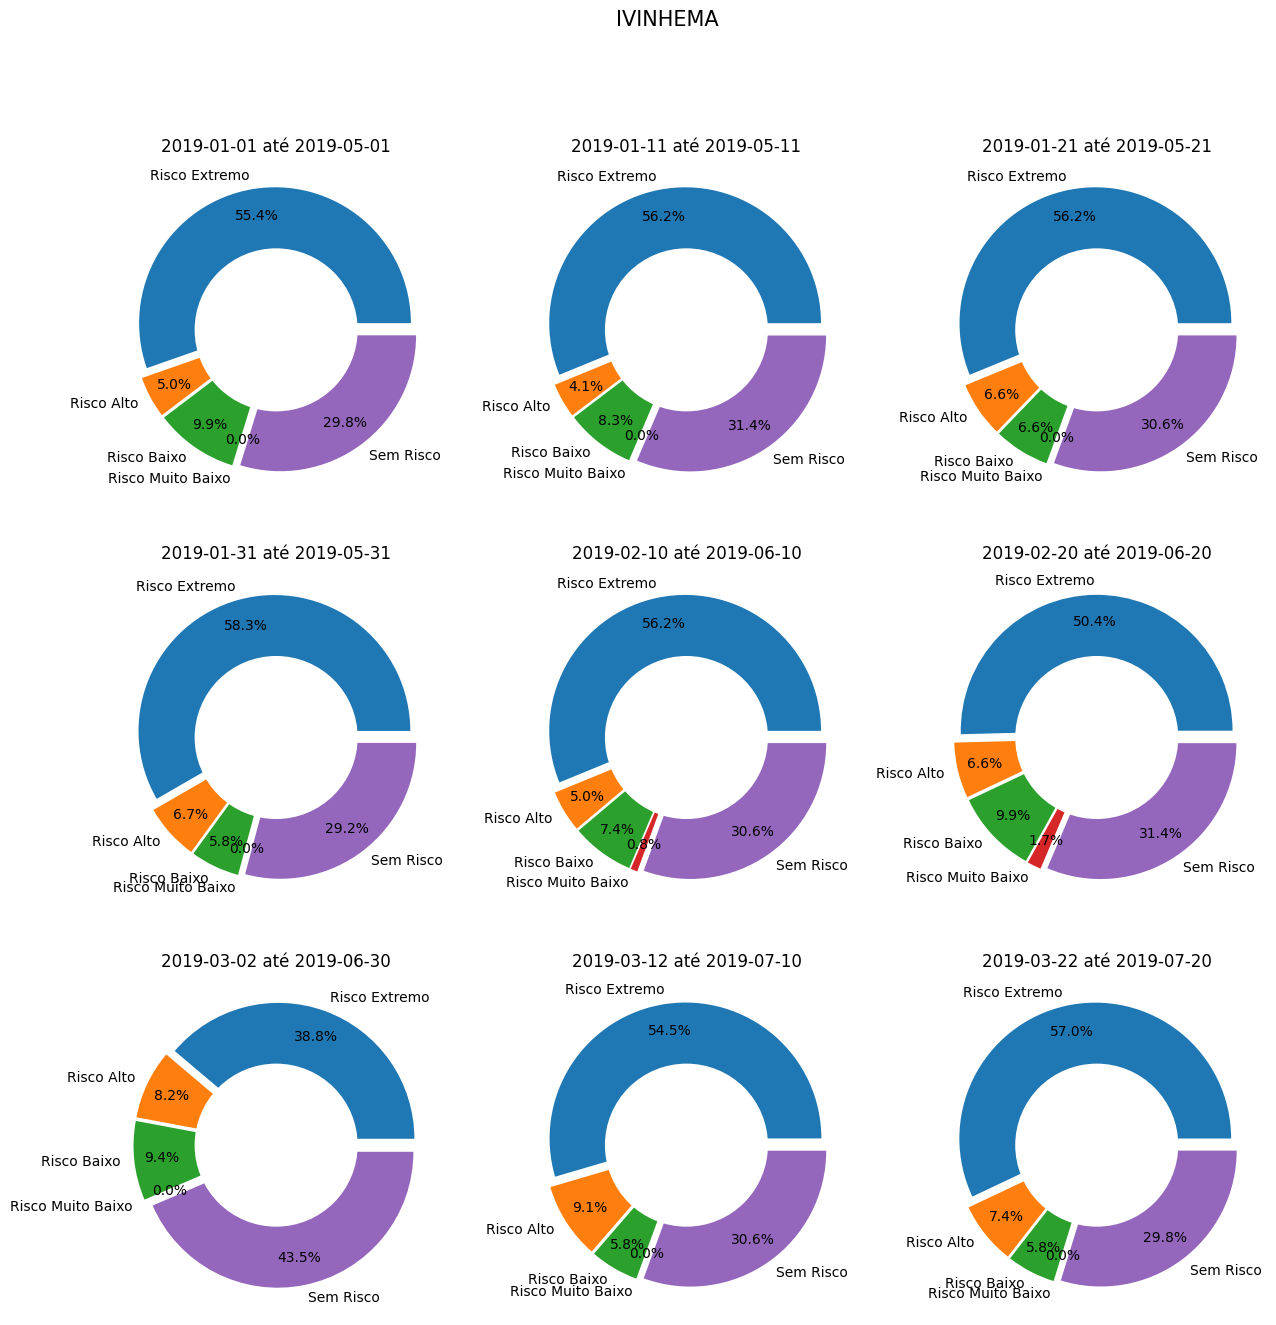

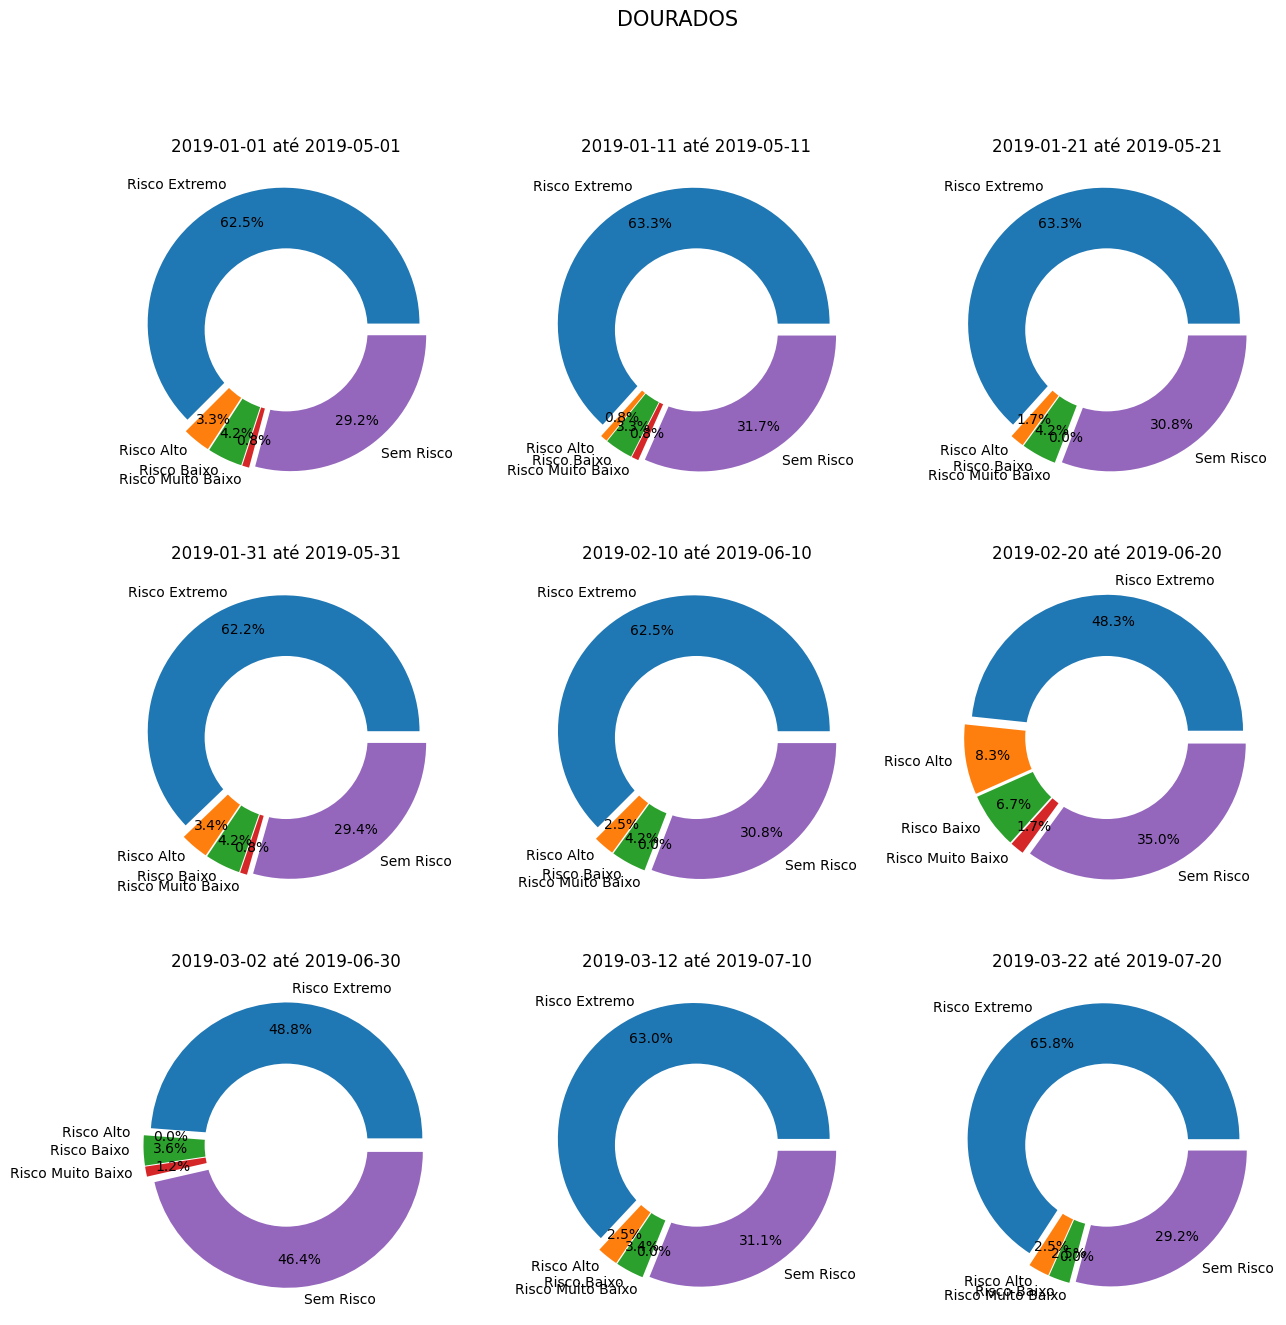

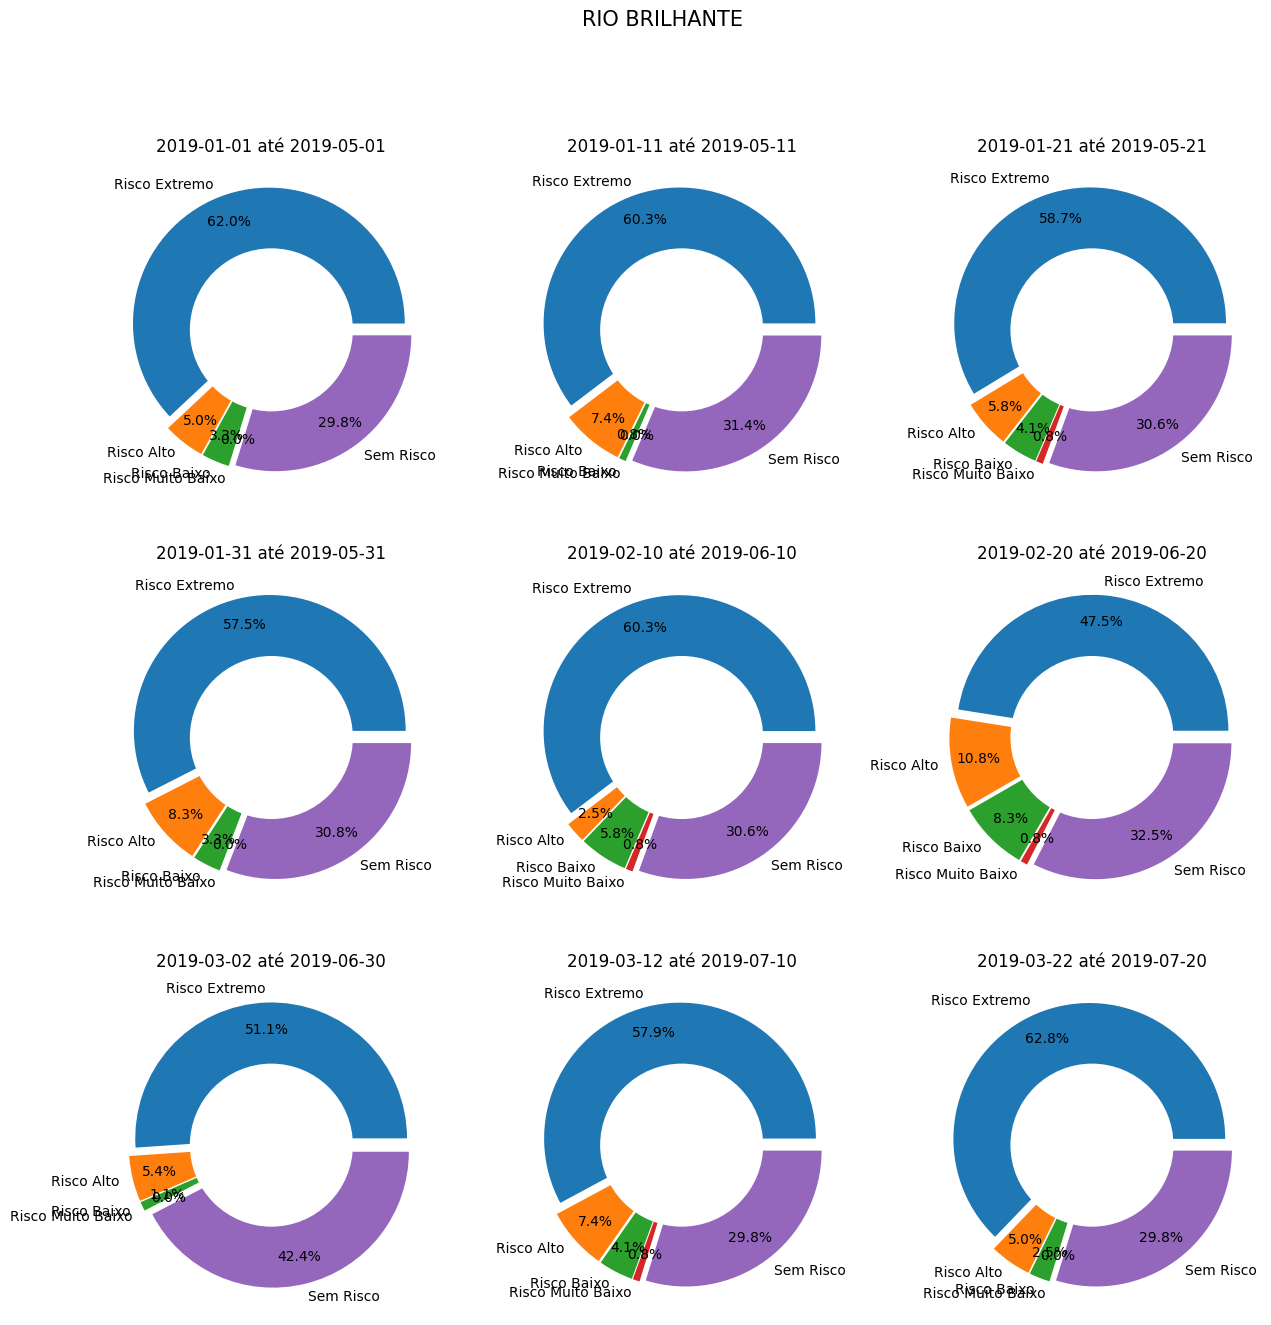

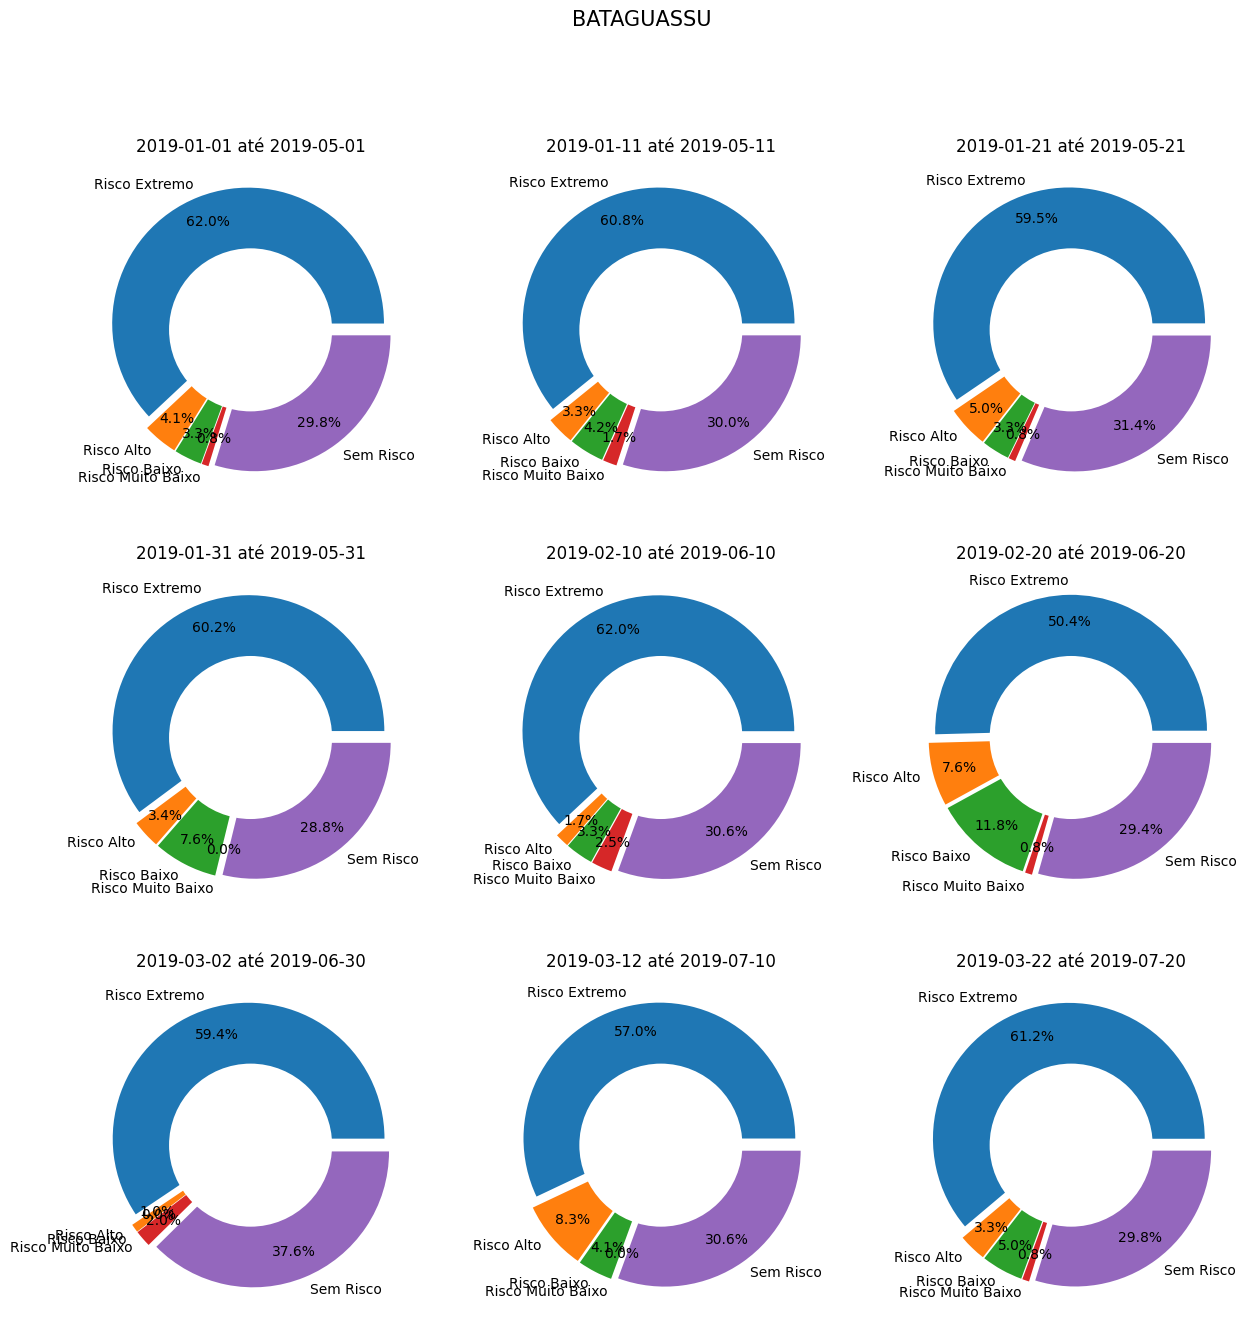

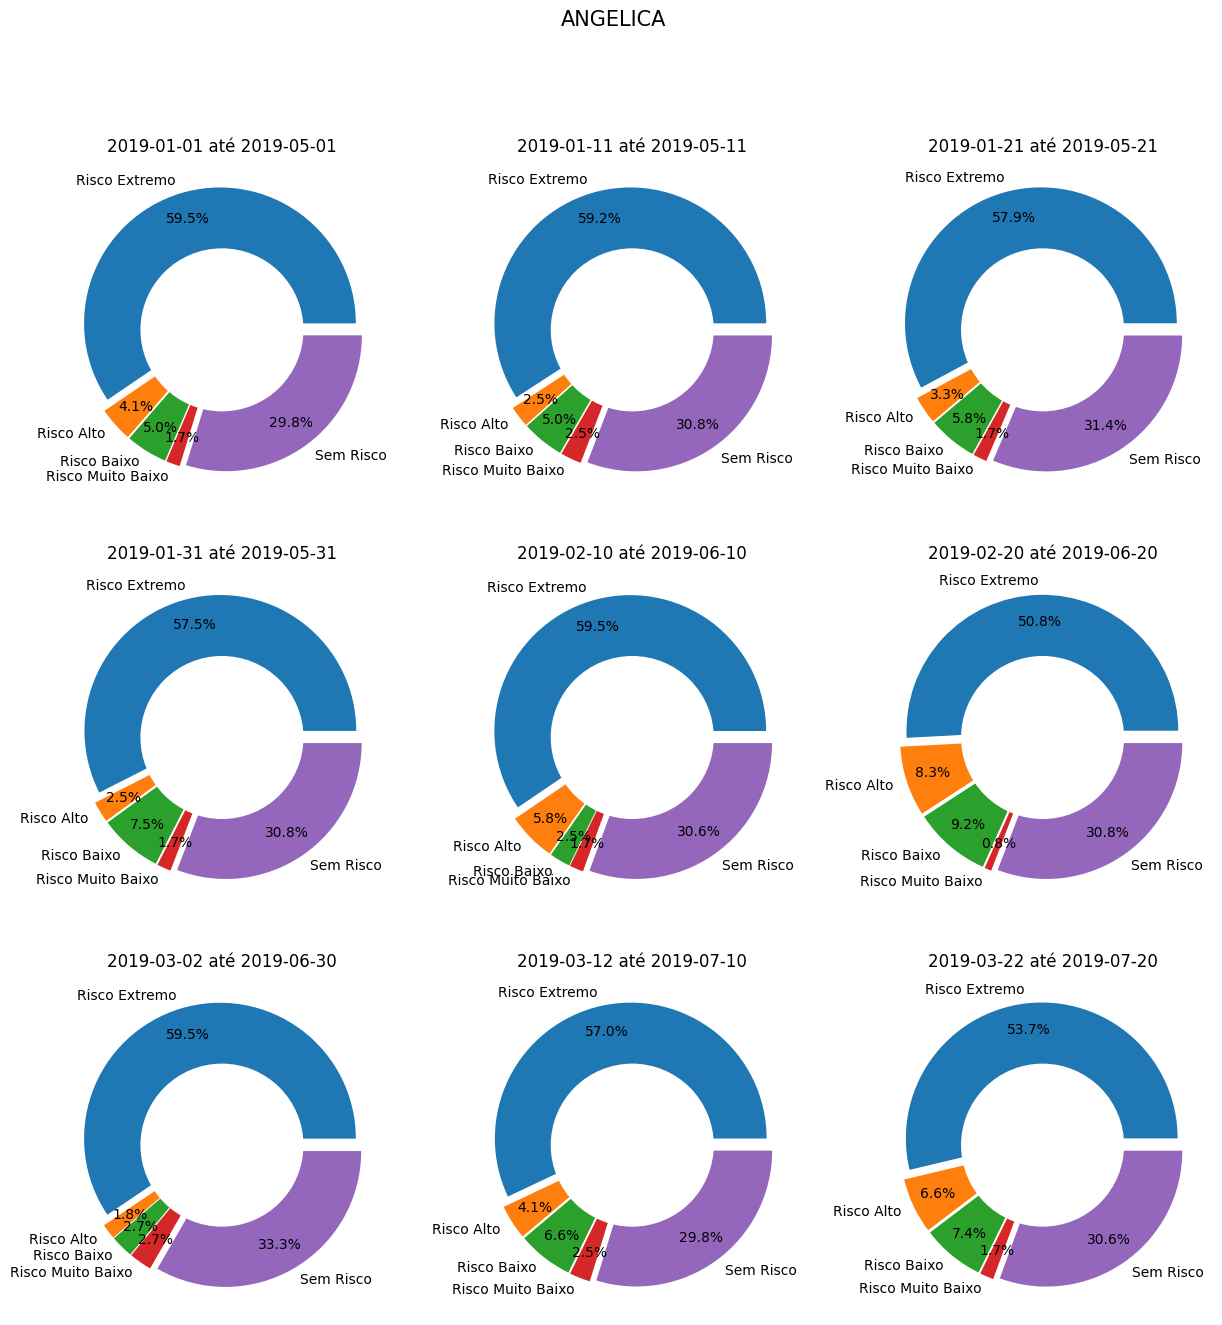

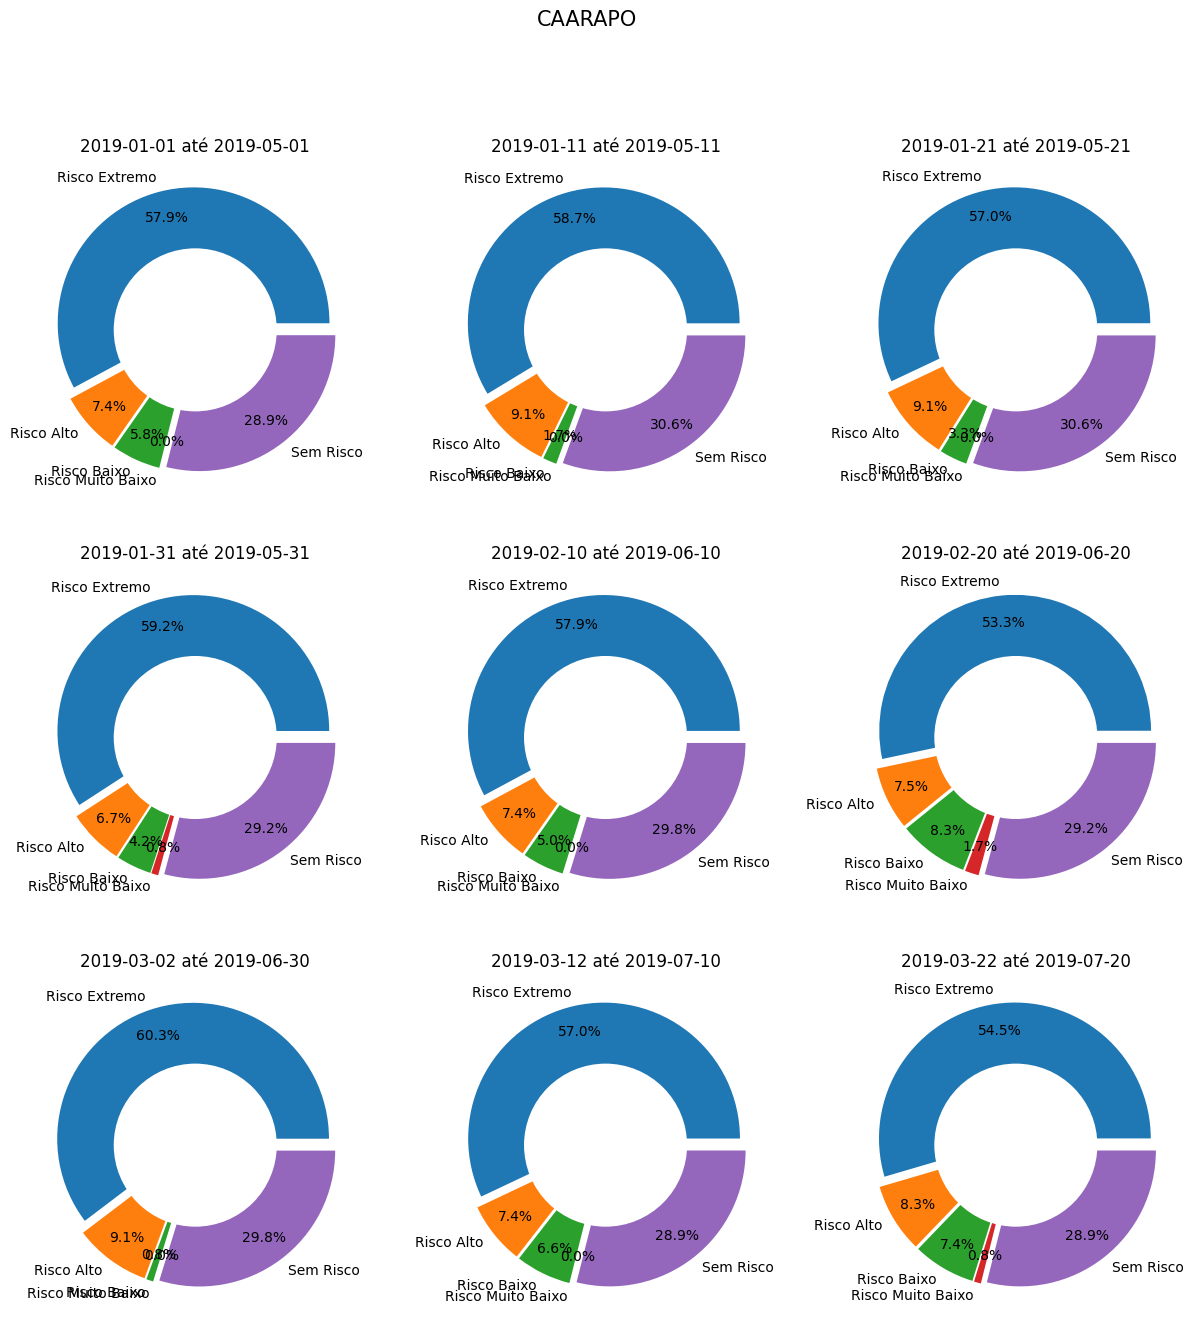

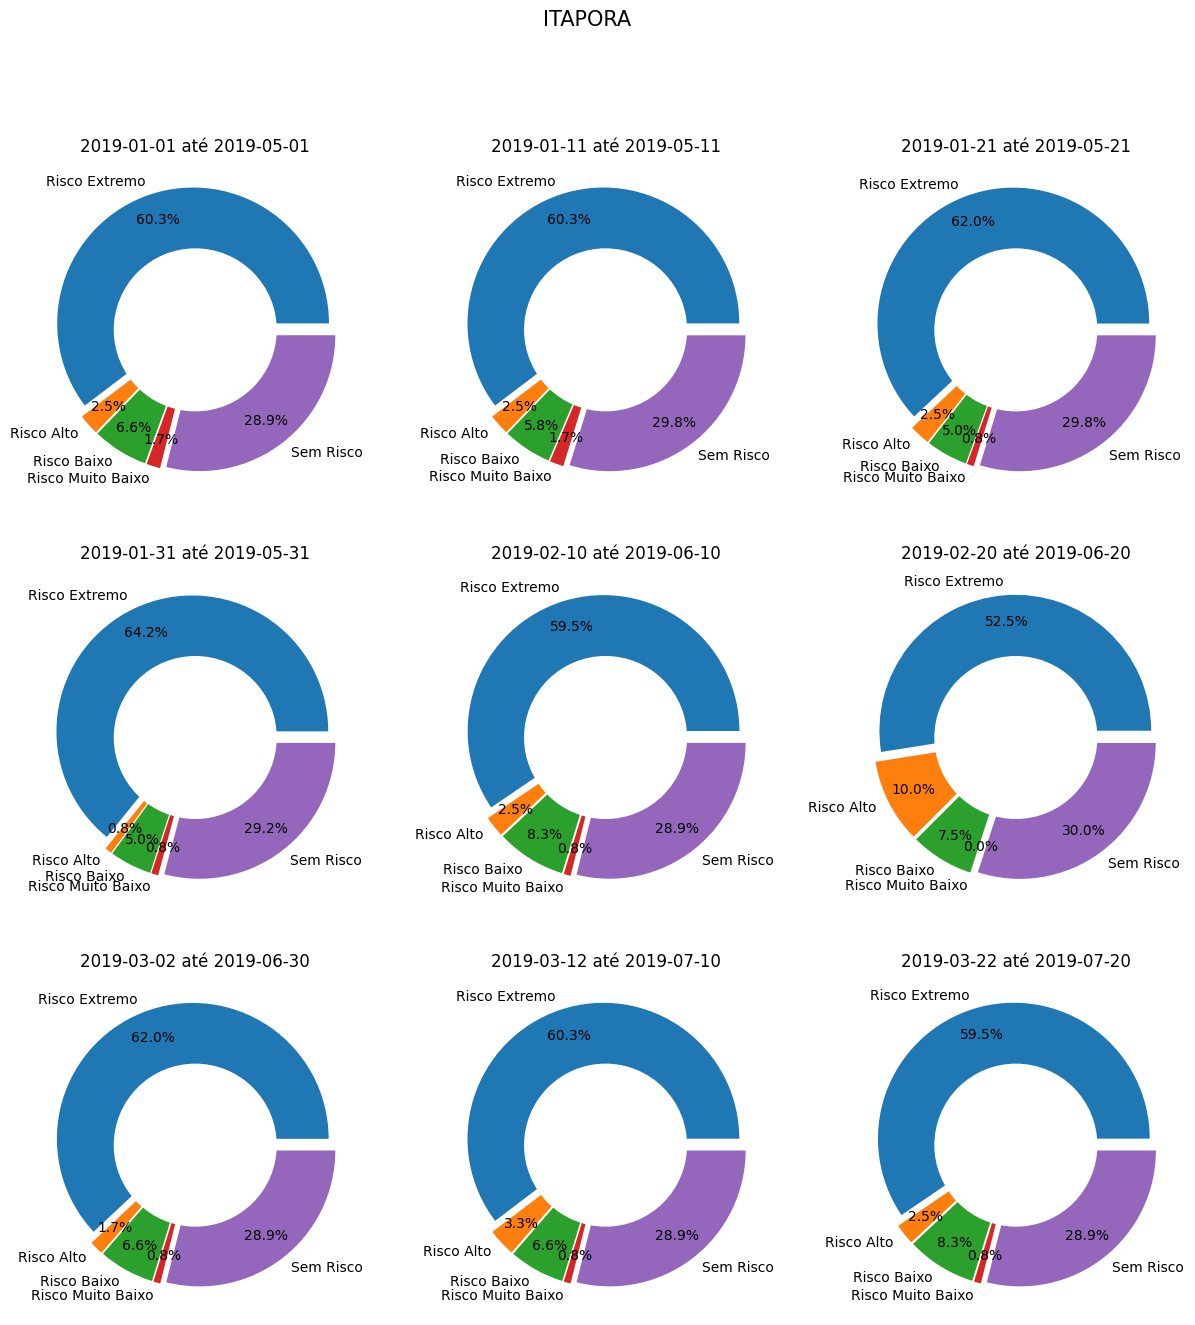

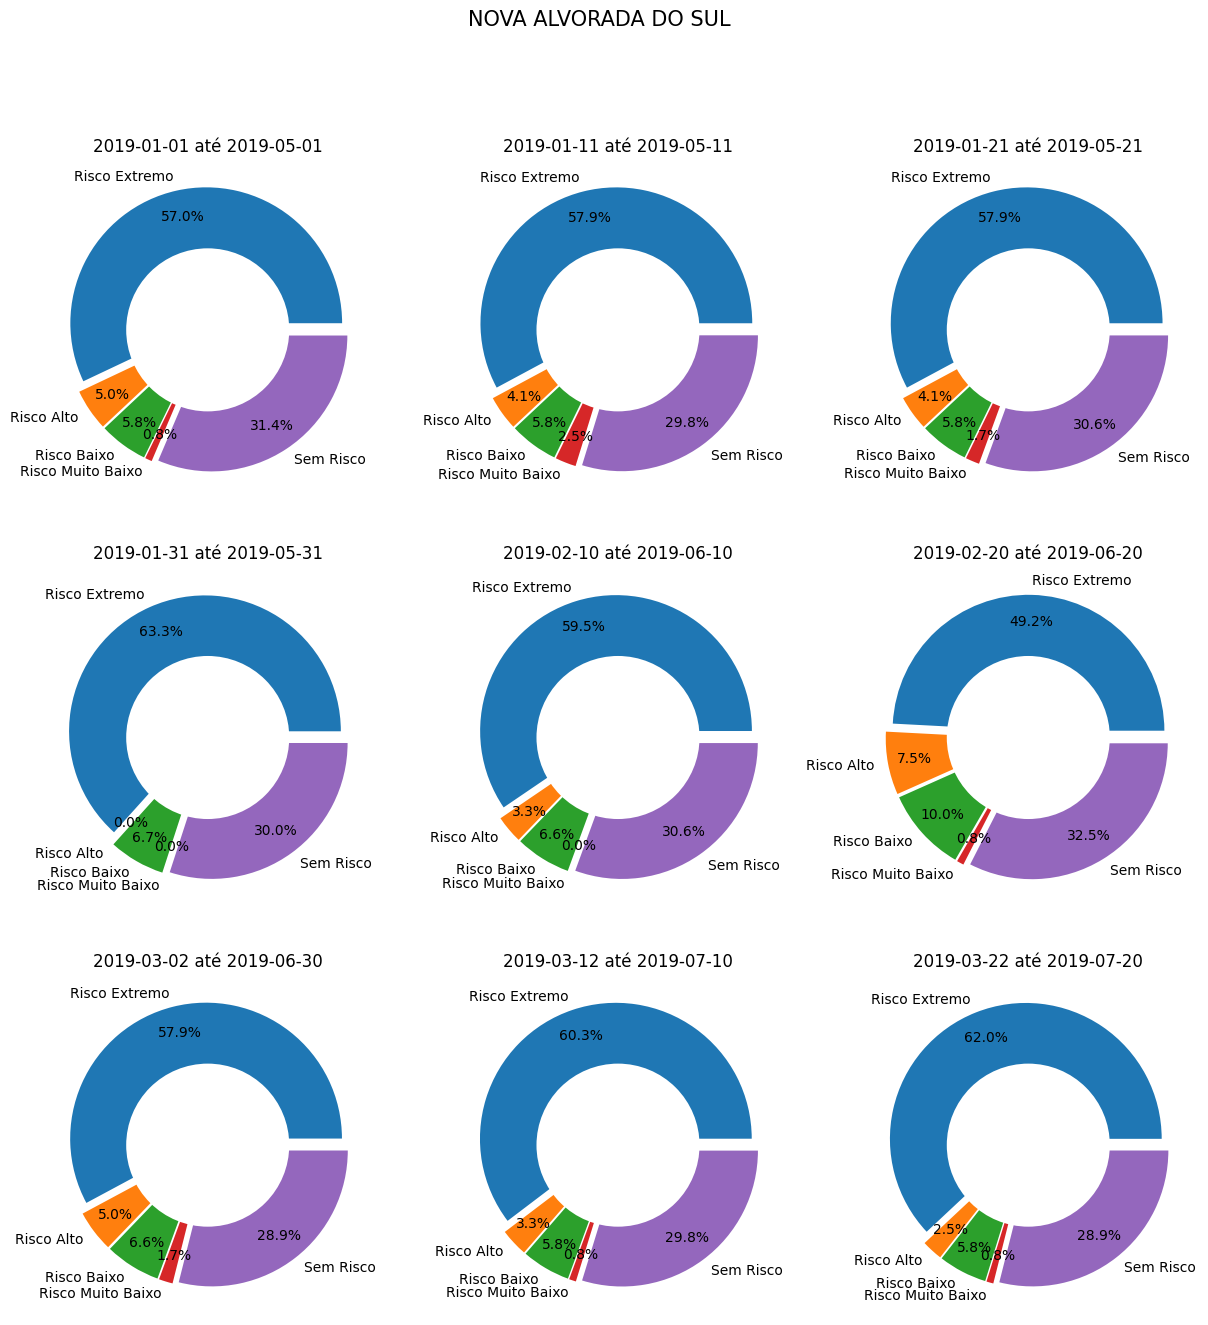

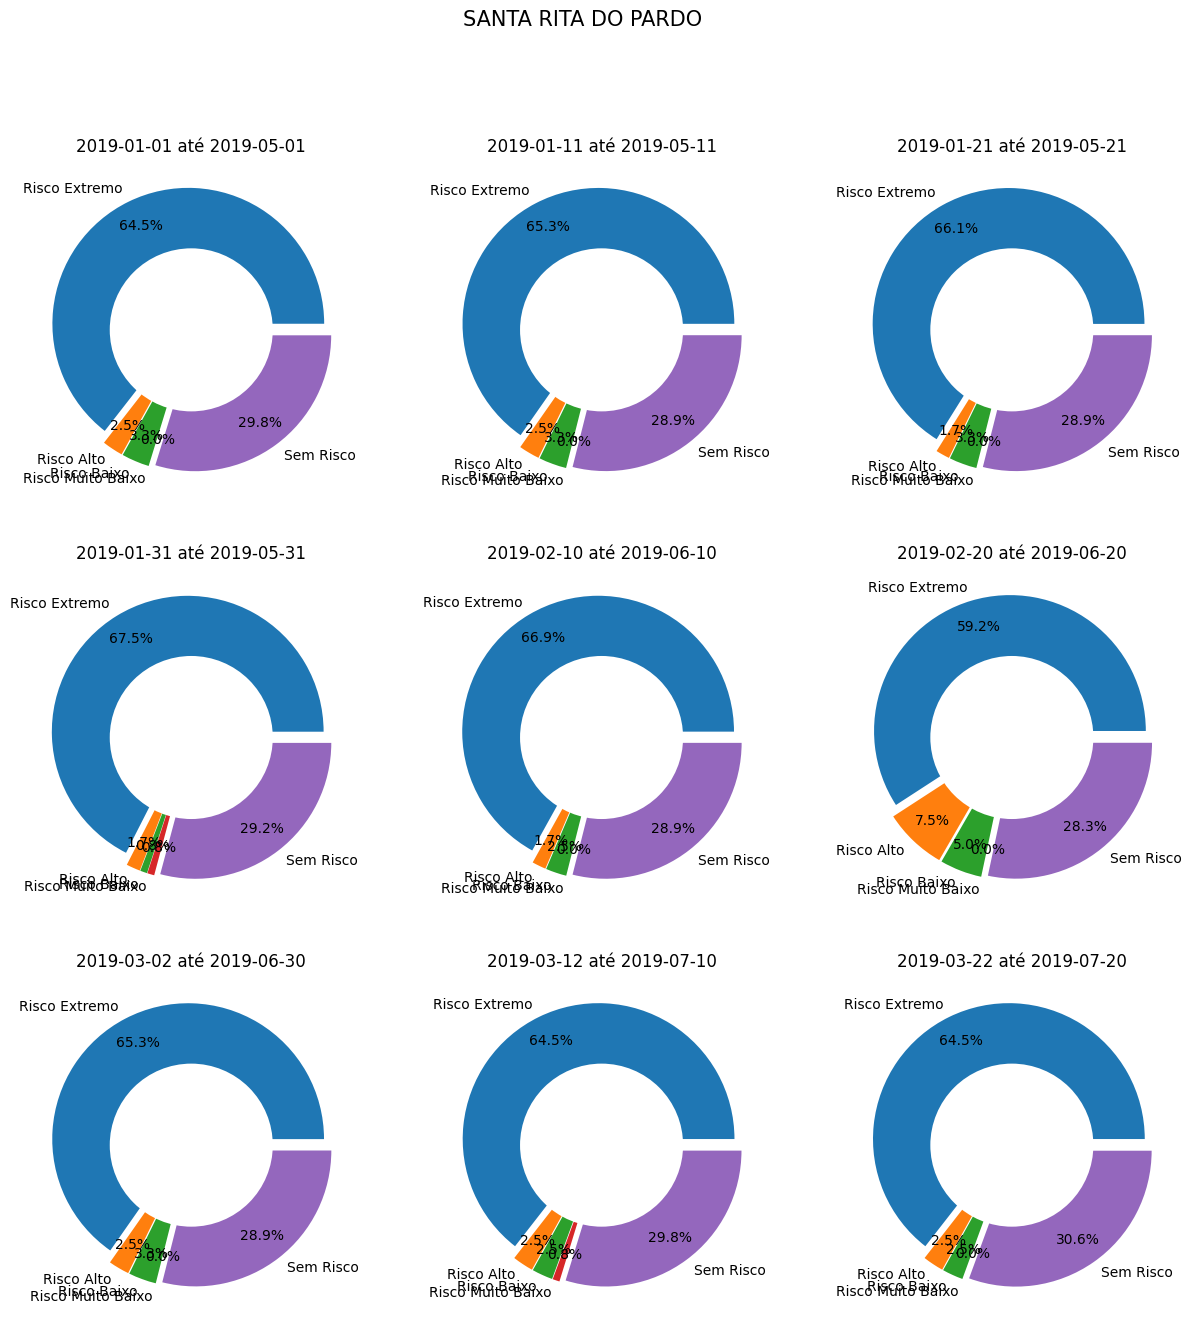

In [70]:
colors = ['#fe0000', '#0000fe', '#ffff00', '#adff30', '#fea500']
for j in range(9):
    fig, axs = plt.subplots(nrows=3, ncols=3)
    fig.set_size_inches(15, 15)
    for i, ax in enumerate(axs.reshape(-1)):
        ax.pie(isnas[i].iloc[:,j][:-1], labels=isnas[i].index[:-1], autopct='%1.1f%%', pctdistance=0.8, explode=[.05]*5)
        cc = plt.Circle((0, 0), 0.6, fc='white')
        ax.add_artist(cc)
        ax.title.set_text(isnas[0].columns[i])
    periodo = isnas[j].name
    fig.suptitle(periodo, fontsize=15)
    fig.savefig(f'datasets/isnas/{periodo}.png')

In [22]:
isnas[0].index

Index(['Risco Extremo', 'Risco Alto', 'Risco Baixo', 'Risco Muito Baixo',
       'Sem Risco', 'Erro'],
      dtype='object')